Images taken during the last FISH experiment (2020), on the SP8 Leica microscope.

# Import the python libraries

In [1]:
# To import the files
import glob
from pathlib import Path

# To read the dataframes
import pandas as pd
import numpy as np

# To plot the images
import matplotlib.pyplot as plt
import seaborn as sns

# To analyse the images
from skimage.filters import gaussian, median
from skimage.restoration import estimate_sigma
from skimage.exposure import equalize_hist, adjust_gamma

# To export image in the different formats: png, ...
import imageio

# Eukaryote dataframe

## Load the eukaryote dataframe

In [2]:
# Read the image dataframe parquet file:
df_eukaryote = pd.read_parquet('parquets/df_eukaryote.parquet')

In [3]:
df_eukaryote.head(10)

,file,serie,channel,nbr_frames,shape_X,shape_Y,channel_count,Image.@UniqueID,Channel.@LUTName,Dimension.@DimID_X,...,Dimension.@NumberOfElements_Y,Dimension.@Length_Y,Dimension.@Unit_Y,ATLConfocalSettingDefinition.@ScanSpeed,ATLConfocalSettingDefinition.@Zoom,ATLConfocalSettingDefinition.@PixelDwellTime,ATLConfocalSettingDefinition.DetectorList.Detector.@Name,ATLConfocalSettingDefinition.DetectorList.Detector.@Type,ATLConfocalSettingDefinition.DetectorList.Detector.@Gain,ATLConfocalSettingDefinition.DetectorList.Detector.@Offset
168,200316_1_NoProbes.lif,Image001,0,1,512,512,4,07e1048b-6795-11ea-a94d-002432168676,Blue,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT 3,PMT,600.289921,0.000000
169,200316_1_NoProbes.lif,Image001,1,1,512,512,4,07e1048b-6795-11ea-a94d-002432168676,Green,1,...,512,0.000185,m,400.0,1.000000,0.000003,HyD4 SMD,HyD,350.666885,-0.006667
170,200316_1_NoProbes.lif,Image001,2,1,512,512,4,07e1048b-6795-11ea-a94d-002432168676,Gray,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT Trans,PMT,350.537881,0.000000
171,200316_1_NoProbes.lif,Image001,3,1,512,512,4,07e1048b-6795-11ea-a94d-002432168676,Red,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT 5,PMT,600.404364,0.000000
172,200316_1_NoProbes.lif,Image002,0,1,512,512,4,30830004-6795-11ea-a94d-002432168676,Blue,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT 3,PMT,600.289921,0.000000
173,200316_1_NoProbes.lif,Image002,1,1,512,512,4,30830004-6795-11ea-a94d-002432168676,Green,1,...,512,0.000185,m,400.0,1.000000,0.000003,HyD4 SMD,HyD,350.666885,-0.006667
174,200316_1_NoProbes.lif,Image002,2,1,512,512,4,30830004-6795-11ea-a94d-002432168676,Gray,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT Trans,PMT,350.537881,0.000000
175,200316_1_NoProbes.lif,Image002,3,1,512,512,4,30830004-6795-11ea-a94d-002432168676,Red,1,...,512,0.000185,m,400.0,1.000000,0.000003,PMT 5,PMT,600.404364,0.000000
256,200316_3_Triton_Probes.lif,Image001,0,1,632,632,4,fbbd1930-6793-11ea-a94d-002432168676,Blue,1,...,632,0.000037,m,400.0,5.000013,0.000003,PMT 3,PMT,600.289921,0.000000
257,200316_3_Triton_Probes.lif,Image001,1,1,632,632,4,fbbd1930-6793-11ea-a94d-002432168676,Green,1,...,632,0.000037,m,400.0,5.000013,0.000003,HyD4 SMD,HyD,350.666885,-0.006667


In [4]:
#Scale bar results in pixels:
df_eukaryote['scale_bar_10um'] = (0.000010*df_eukaryote['Dimension.@NumberOfElements_X'])/df_eukaryote['Dimension.@Length_X']
df_eukaryote['scale_bar_10um']

168     27.747098
169     27.747098
170     27.747098
171     27.747098
172     27.747098
          ...    
451    171.252039
452    171.252039
453    171.252039
454    171.252039
455    171.252039
Name: scale_bar_10um, Length: 484, dtype: float64

In [5]:
df_eukaryote['scale_bar_10um_unit'] = 'px'
df_eukaryote['scale_bar_10um_unit']

168    px
169    px
170    px
171    px
172    px
       ..
451    px
452    px
453    px
454    px
455    px
Name: scale_bar_10um_unit, Length: 484, dtype: object

In [6]:
df_eukaryote.loc[267]

file                                                                    200316_3_Triton_Probes.lif
serie                                                                                     Image003
channel                                                                                          3
nbr_frames                                                                                       1
shape_X                                                                                        632
shape_Y                                                                                        632
channel_count                                                                                    4
Image.@UniqueID                                               4ea5a0c7-6794-11ea-a94d-002432168676
Channel.@LUTName                                                                               Red
Dimension.@DimID_X                                                                               1
Dimension.

In [7]:
df_eukaryote.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 168 to 455
Data columns (total 26 columns):
 #   Column                                                      Non-Null Count  Dtype   
---  ------                                                      --------------  -----   
 0   file                                                        484 non-null    object  
 1   serie                                                       484 non-null    object  
 2   channel                                                     484 non-null    int64   
 3   nbr_frames                                                  484 non-null    int64   
 4   shape_X                                                     484 non-null    int64   
 5   shape_Y                                                     484 non-null    int64   
 6   channel_count                                               484 non-null    int64   
 7   Image.@UniqueID                                             484 non-null    ob

## Check the values of interest for the analysis

In [8]:
np.unique(df_eukaryote[['Dimension.@NumberOfElements_X', 'Dimension.@NumberOfElements_Y']].values, return_counts=True)

(array([320, 512, 632, 3144], dtype=object), array([  8, 280, 392, 288]))

In [9]:
df_eukaryote['ATLConfocalSettingDefinition.@ScanSpeed'].unique()

array([400.])

Same scan speed used for all the images: 400 Hz

In [10]:
df_eukaryote['ATLConfocalSettingDefinition.@Zoom'].value_counts()

5.000013     268
1.000000     212
10.000025      4
Name: ATLConfocalSettingDefinition.@Zoom, dtype: int64

Three different zoom setting are used: 1, 5 and 10 time.

In [11]:
df_eukaryote['ATLConfocalSettingDefinition.@PixelDwellTime'].value_counts()

2.562500e-06    196
5.125000e-07    144
3.162500e-06    140
5.075000e-06      4
Name: ATLConfocalSettingDefinition.@PixelDwellTime, dtype: int64

In [12]:
df_eukaryote.groupby('Channel.@LUTName')['ATLConfocalSettingDefinition.DetectorList.Detector.@Gain'].value_counts()

Channel.@LUTName  ATLConfocalSettingDefinition.DetectorList.Detector.@Gain
Blue              600.289921                                                  114
                  600.308995                                                    7
Gray              350.537881                                                  114
                  400.034333                                                    7
Green             350.666885                                                  114
                  349.980225                                                    7
Red               600.881209                                                   58
                  600.404364                                                   56
                  600.862135                                                    7
Name: ATLConfocalSettingDefinition.DetectorList.Detector.@Gain, dtype: int64

In [13]:
df_eukaryote.groupby('Channel.@LUTName')['ATLConfocalSettingDefinition.DetectorList.Detector.@Offset'].value_counts()

Channel.@LUTName  ATLConfocalSettingDefinition.DetectorList.Detector.@Offset
Blue               0.000000                                                     114
                  -0.073333                                                       7
Gray               0.000000                                                     121
Green             -0.006667                                                     121
Red                0.000000                                                     121
Name: ATLConfocalSettingDefinition.DetectorList.Detector.@Offset, dtype: int64

# Load the numpy files containing the images

In [14]:
image_arrays = sorted(glob.glob('../image_processing/image_arrays/*.npy'))

In [15]:
image_arrays

['../image_processing/image_arrays/0_images_320_320.npy',
 '../image_processing/image_arrays/1_images_512_512.npy',
 '../image_processing/image_arrays/2_images_600_600.npy',
 '../image_processing/image_arrays/3_images_632_632.npy',
 '../image_processing/image_arrays/4_images_1408_1408.npy',
 '../image_processing/image_arrays/5_images_1872_1872.npy',
 '../image_processing/image_arrays/6_images_2480_2480.npy',
 '../image_processing/image_arrays/7_images_2608_2608.npy',
 '../image_processing/image_arrays/8_images_3144_3144.npy']

In [16]:
image_info = pd.read_parquet('image_info_dataframe.parquet')

In [17]:
shape_dict = image_info.groupby(['shape_X', 'shape_Y']).indices

In [18]:
name_list = []
shape_list = []
arrays = dict()

for indices, array in zip(shape_dict, image_arrays):
    name_list.append(Path(array).stem)
    shape_list.append(indices)
    images = np.load(array)
    for idx, img in zip(shape_dict[indices], images):
        arrays.update({idx:img})

In [19]:
len(arrays)

1188

In [20]:
name_list

['0_images_320_320',
 '1_images_512_512',
 '2_images_600_600',
 '3_images_632_632',
 '4_images_1408_1408',
 '5_images_1872_1872',
 '6_images_2480_2480',
 '7_images_2608_2608',
 '8_images_3144_3144']

In [21]:
shape_list

[(320, 320),
 (512, 512),
 (600, 600),
 (632, 632),
 (1408, 1408),
 (1872, 1872),
 (2480, 2480),
 (2608, 2608),
 (3144, 3144)]

# Save fluorescente channel images

## gfp channel

In [22]:
def get_images_from_idx(index_list):
    ''' Return a list of images corresponding to the indexes'''
    
    images = []
    
    for idx in index_list:
        images.append(arrays[idx])
    return images

In [23]:
# DIC channels:
idx_gfp = df_eukaryote.loc[(df_eukaryote['Channel.@LUTName'] == 'Green')].index.tolist()
img_gfp = get_images_from_idx(idx_gfp)

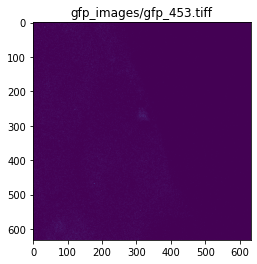

In [24]:
for idx, img in zip(idx_gfp, img_gfp):
    plt.imshow(img)
    plt.title(f'gfp_images/gfp_{idx}.tiff')
plt.

In [24]:
for idx, img in zip(idx_gfp, img_gfp):
    imageio.imwrite(f'gfp_images/gfp_{idx}.tiff', img)

## probe channel

In [25]:
# DIC channels:
idx_probe = df_eukaryote.loc[(df_eukaryote['Channel.@LUTName'] == 'Red')].index.tolist()
img_probe = get_images_from_idx(idx_probe)

In [26]:
for idx, img in zip(idx_probe, img_probe):
    imageio.imwrite(f'probe_images/probe_{idx}.tiff', img)